# Australian Federal Election Polling 2022

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Get-Wikipedia-polling-data" data-toc-modified-id="Get-Wikipedia-polling-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get Wikipedia polling data</a></span></li><li><span><a href="#Data-cleaning" data-toc-modified-id="Data-cleaning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data cleaning</a></span></li><li><span><a href="#Data-quality-checks" data-toc-modified-id="Data-quality-checks-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data quality checks</a></span></li><li><span><a href="#Attribute-undecideds-(and-force-polls-to-sum-to-100-percent)" data-toc-modified-id="Attribute-undecideds-(and-force-polls-to-sum-to-100-percent)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Attribute undecideds (and force polls to sum to 100 percent)</a></span></li><li><span><a href="#Calculate-2pp-based-on-preference-flows-at-the-2019-election" data-toc-modified-id="Calculate-2pp-based-on-preference-flows-at-the-2019-election-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Calculate 2pp based on preference flows at the 2019 election</a></span></li><li><span><a href="#Quick-plots" data-toc-modified-id="Quick-plots-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Quick plots</a></span><ul class="toc-item"><li><span><a href="#National-2PP-plot" data-toc-modified-id="National-2PP-plot-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>National 2PP plot</a></span></li><li><span><a href="#Plot-calculated-2pp" data-toc-modified-id="Plot-calculated-2pp-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Plot calculated 2pp</a></span></li><li><span><a href="#Primary-votes" data-toc-modified-id="Primary-votes-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Primary votes</a></span></li><li><span><a href="#Preferred-Prime-Minister" data-toc-modified-id="Preferred-Prime-Minister-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Preferred Prime Minister</a></span></li><li><span><a href="#Satisfaction-charts" data-toc-modified-id="Satisfaction-charts-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>Satisfaction charts</a></span></li></ul></li><li><span><a href="#Save-files" data-toc-modified-id="Save-files-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Save files</a></span></li><li><span><a href="#Check-for-any-problems-with-data-capture-and-cleaning" data-toc-modified-id="Check-for-any-problems-with-data-capture-and-cleaning-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Check for any problems with data capture and cleaning</a></span></li></ul></div>

## Python set-up

In [1]:
# data science imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm

# standard python imports
import platform, sys, os, pathlib
from io import StringIO
from typing import List
import re

# local imports
import common
from common import COLOR_COALITION, COLOR_LABOR, COLOR_OTHER, COLOR_GREEN

In [2]:
# Versions ...
print(f'python: {platform.python_version()}')
print(f'numpy: {np.__version__}')
print(f'pandas: {pd.__version__}')
print(f'matplotlib: {mpl.__version__}')
print(f're: {re.__version__}')
print(f'statsmodels: {sm.__version__}')

python: 3.9.7
numpy: 1.21.4
pandas: 1.3.4
matplotlib: 3.5.0
re: 2.2.1
statsmodels: 0.13.1


In [3]:
# pandas 
pd.set_option('display.max_rows', 1000)

In [4]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')
s_args = {'lfooter': 'Polling data from Wikipedia'}
MODEL_NAME = 'LOWESS Regression'

In [5]:
# saving downloaded files
DATA_DIR = '../data'
pathlib.Path(DATA_DIR).mkdir(parents=True, exist_ok=True)
DATA_DIR += '/'

In [6]:
DIAGNOSTICS = True

In [7]:
warnings = []

def warn(message):
    print(message)
    warnings.append(message)
    
def check_warnings():
    if warnings:
        for i, w in enumerate(warnings):
            print(f'{i+1}: {w}')

## Get Wikipedia polling data

In [8]:
WIKIURL = (
    'https://en.wikipedia.org/wiki/'
    'Opinion_polling_for_the_next_Australian_federal_election'
)
text = common.get_url_text(WIKIURL)

In [9]:
def extract_polling_tables(text):
    sought = {
        # description:              table number in wiki page
        "Voting intention":         0,
        "Preferred prime minister": 2,
    }

    table_dict = {}
    for item, table_number in sought.items():
        table_dict[item] = common.get_table_from_text(table_number, text)
  
    return table_dict

table_dict = extract_polling_tables(text)

In [10]:
if DIAGNOSTICS:
    # column names in the raw data capture ...
    for n, t in table_dict.items():
        print(n)
        print(t.columns)
        print('-'*30)

Voting intention
MultiIndex([(          'Date', 'Unnamed: 0_level_1'),
            (         'Brand', 'Unnamed: 1_level_1'),
            ('Interview mode', 'Unnamed: 2_level_1'),
            (   'Sample size', 'Unnamed: 3_level_1'),
            (  'Primary vote',               'L/NP'),
            (  'Primary vote',                'ALP'),
            (  'Primary vote',                'GRN'),
            (  'Primary vote',                'ONP'),
            (  'Primary vote',                'OTH'),
            (  'Primary vote',                'UND'),
            (      '2pp vote',               'L/NP'),
            (      '2pp vote',                'ALP'),
            (      '2pp vote',                'UND')],
           )
------------------------------
Preferred prime minister
MultiIndex([(                    'Date', 'Unnamed: 0_level_1'),
            (                   'Brand', 'Unnamed: 1_level_1'),
            (                    'Firm', 'Unnamed: 2_level_1'),
            (      

In [11]:
# Web scraping is always a little fragile
# we check the tables extracted here:

for key, table in table_dict.items():
    print(key)
    display(table.iloc[:3])
    print('=' * 40)

Voting intention


Date               Brand     Interview mode  \
                 Unnamed: 0_level_1  Unnamed: 1_level_1 Unnamed: 2_level_1   
0        13–14, 20–21 November 2021       Roy Morgan[1]   Telephone/Online   
1               10–13 November 2021  Newspoll-YouGov[2]             Online   
2  30–31 October, 6–7 November 2021       Roy Morgan[3]   Telephone/Online   

         Sample size Primary vote                                 2pp vote  \
  Unnamed: 3_level_1         L/NP    ALP    GRN   ONP    OTH  UND     L/NP   
0               2795        35.5%  35.5%    12%  3.5%  13.5%  NaN    44.5%   
1               1524          37%    38%    11%    2%    12%  NaN      47%   
2               2723        36.5%    35%  11.5%    3%    14%  NaN    46.5%   

               
     ALP  UND  
0  55.5%  NaN  
1    53%  NaN  
2  53.5%  NaN

Preferred prime minister


Date              Brand               Firm  \
              Unnamed: 0_level_1 Unnamed: 1_level_1 Unnamed: 2_level_1   
0            10–13 November 2021        Newspoll[2]             YouGov   
1             20–23 October 2021        Newspoll[9]             YouGov   
2  29 September – 2 October 2021       Newspoll[13]             YouGov   

      Interview mode        Sample size Preferred Prime Minister           \
  Unnamed: 3_level_1 Unnamed: 4_level_1                 Morrison Albanese   
0             Online                NaN                      46%      38%   
1             Online                NaN                      48%      34%   
2             Online             1545.0                      47%      34%   

              Morrison                          Albanese               \
  Don't Know Satisfied Dissatisfied Don't Know Satisfied Dissatisfied   
0        16%       44%          52%         4%       37%          48%   
1        18%       46%          50%         4%       37%          46%   
2        19%       48%          49%         3%       37%          47%   

              
  Don't Know  
0        15%  
1        17%  
2        16%

## Data cleaning

In [12]:
# These are the functions for data cleaning ...

# Common unicode symbols
endash = '\u2013'
emdash = '\u2014'
hyphen = '\u002D'
tilde = '~'
comma = ','


def remove_event_rows(t: pd.DataFrame) -> pd.DataFrame:
    """Remove the event marker rows."""
    t = t.loc[t[t.columns[1]] != t[t.columns[2]]]
    t = t[t[t.columns[1]].notna()]
    return t


def drop_empty(t: pd.DataFrame) -> pd.DataFrame:
    """Remove all empty rows and columns."""
    t = t.dropna(axis=0, how='all')
    t = t.dropna(axis=1, how='all')
    return t


def fix_numerical_cols(t: pd.DataFrame) -> pd.DataFrame:
    """Convert selected columns from strings to numeric data type."""
    
    # some constants
    fixable_cols = (
        'Primary vote', '2pp vote',
        'Preferred Prime Minister',
        'Morrison', 'Albanese',
        'Sample size', 
    )

    # navigate fixable columns and convert to numerical dtype
    for c in t.columns[t.columns.get_level_values(0).isin(fixable_cols)]:
        if str(t[c].dtype) in ['object', ]:
            t[c] = (
                t[c]
                .str.replace('\[.*\]$', '', regex=True) # remove footnotes
                .str.replace('%', '')    # remove percent symbol
                .str.replace(tilde, '')  # replace tilde with nothing
                .str.replace(hyphen, '') # replace hyphen with nothing
                .str.replace(endash, '') # replace hyphen with nothing
                .str.replace(emdash, '') # replace hyphen with nothing
                .str.replace('n/a', '')  # replace 'n/a' with nothing
                .str.strip()             # strip white space
                .replace('', np.nan)     # NaN empty lines
                .astype(float)           # float
            )
    return t


def fix_column_names(t: pd.DataFrame) -> pd.DataFrame:
    """Replace 'Unnamed' column names with ''."""
    
    replacements = {}
    for c in t.columns:
        if 'Unnamed' in c[1]:
            replacements[c[1]] = ''
    if replacements:
        t = t.rename(columns=replacements, level=1)
    return t


def remove_footnotes(t: pd.DataFrame) -> pd.DataFrame:
    """Remove Wikipedia footnote references from the Brand column"""
    
    BRAND = 'Brand'
    if BRAND not in t.columns.get_level_values(0):
        warn(f'WARNING: no "{BRAND}" column in remove_footnotes()')
        return t
    col = t.columns[t.columns.get_level_values(0) == BRAND]
    assert(len(col) == 1)
    t.loc[:, col] = (
        t.loc[:, col] # returns a single column DataFrame
        .pipe(lambda x: x[x.columns[0]]) # make as Series
        .str.replace('\[.*\]$', '', regex=True) # remove footnotes
        .str.strip() # remove any leading/trailing whitespaces
    )
    return t


def get_mean_date(tokens: List[str]) -> pd.Timestamp:
    """Extract the middle date from a list of date tokens."""
    
    last_day = None
    day, month, year = None, None, None
    while tokens:
        token = tokens.pop()
        if re.match(r'[0-9]{4}', token):
            year = token
        elif re.match(r'[A-Za-z]+', token):
            month = token
        elif re.match(r'[0-9]{1,2}', token):
            day = token
        else:
            warn(f'Warning: {token} not recognised in get_mean_date()')

        if (last_day is None and day is not None 
            and month is not None and year is not None):
            last_day = pd.Timestamp(f'{year} {month[:3]} {day}')
    
    # sadly we have cases of this ...
    if not last_day:
        if day is None:
            day = 15 # middle of month
        last_day = pd.Timestamp(f'{year} {month[:3]} {day}')

    # get the middle date
    first_day = pd.Timestamp(f'{year} {month[:3]} {day}')
    if first_day > last_day:
        warn(f'Check these dates in get_mean_date(): {first_day} {last_day}')
    
    return (first_day + ((last_day - first_day) / 2)).date()


def tokenise_dates(dates: pd.Series) -> pd.Series:
    """Return the date as a list of tokens."""
    return (
        dates
        .str.replace(endash, hyphen)
        .str.replace(emdash, hyphen)
        .str.split(r'[\-,\s]+')
    )


def middle_date(t: pd.DataFrame) -> pd.DataFrame:
    """Get the middle date in the date range, into column 'Mean Date'."""
    
    # assumes dates in strings are ordered from first to last
    tokens = tokenise_dates(t['Date'])
    t['Mean Date'] = tokens.apply(get_mean_date).astype('datetime64[ns]')
    return t


def clean(table: pd.DataFrame) -> pd.DataFrame:
    """Clean the extracted data tables."""
    
    t = table.copy()
    t = remove_event_rows(t)
    t = drop_empty(t)
    t = fix_numerical_cols(t)
    t = fix_column_names(t)
    t = remove_footnotes(t)
    t = middle_date(t)
    t = t.set_index(('Mean Date', ''))
    t = t.sort_index(ascending=True)
    # Note we keep the hierarchical index at this point
    # because it makes the checking row additions simpler
    
    return t

In [13]:
cleaned = {}
for key, table in table_dict.items():
    cleaned[key] = clean(table)
    print(key)
    display(cleaned[key].tail(3))

Voting intention


Date            Brand  \
                                                                   
(Mean Date, )                                                      
2021-11-03     30–31 October, 6–7 November 2021       Roy Morgan   
2021-11-11                  10–13 November 2021  Newspoll-YouGov   
2021-11-17           13–14, 20–21 November 2021       Roy Morgan   

                 Interview mode Sample size Primary vote                   \
                                                    L/NP   ALP   GRN  ONP   
(Mean Date, )                                                               
2021-11-03     Telephone/Online      2723.0         36.5  35.0  11.5  3.0   
2021-11-11               Online      1524.0         37.0  38.0  11.0  2.0   
2021-11-17     Telephone/Online      2795.0         35.5  35.5  12.0  3.5   

                        2pp vote            
                OTH UND     L/NP   ALP UND  
(Mean Date, )                               
2021-11-03     14.0 NaN     46.5  53.5 NaN  
2021-11-11     12.0 NaN     47.0  53.0 NaN  
2021-11-17     13.5 NaN     44.5  55.5 NaN

Preferred prime minister


Date     Brand    Firm Interview mode  \
                                                                                
(Mean Date, )                                                                   
2021-09-30     29 September – 2 October 2021  Newspoll  YouGov         Online   
2021-10-21                20–23 October 2021  Newspoll  YouGov         Online   
2021-11-11               10–13 November 2021  Newspoll  YouGov         Online   

              Sample size Preferred Prime Minister                      \
                                          Morrison Albanese Don't Know   
(Mean Date, )                                                            
2021-09-30         1545.0                     47.0     34.0       19.0   
2021-10-21            NaN                     48.0     34.0       18.0   
2021-11-11            NaN                     46.0     38.0       16.0   

               Morrison                          Albanese               \
              Satisfied Dissatisfied Don't Know Satisfied Dissatisfied   
(Mean Date, )                                                            
2021-09-30         48.0         49.0        3.0      37.0         47.0   
2021-10-21         46.0         50.0        4.0      37.0         46.0   
2021-11-11         44.0         52.0        4.0      37.0         48.0   

                          
              Don't Know  
(Mean Date, )             
2021-09-30          16.0  
2021-10-21          17.0  
2021-11-11          15.0

## Data quality checks

In [14]:
vi = cleaned['Voting intention'].copy()
attitudinal = cleaned['Preferred prime minister'].copy()

In [15]:
def check_row_sums(df: pd.DataFrame, columns: str) -> None:
    """Identify when rows do not add to 100%."""
    
    row_totals = (
        df[
            df.columns[
                df
                .columns
                .get_level_values(0) == columns
            ]
        ]
        .sum(axis=1, skipna=True)
    )
    problematic = (row_totals != 0) & ((row_totals < 99) | (row_totals > 101))

    # If any rows have any row-addition problem ... let's report them
    if problematic.any():
        warn(f'check_row_sums() found issues with {columns}')
        display(df[problematic]) # the problematic rows
        display(row_totals[problematic]) # row-totals for these rows
        print('=' * 50)

In [16]:
check_row_sums(vi, '2pp vote')
check_row_sums(vi, 'Primary vote')

check_row_sums() found issues with Primary vote


Date                           Brand  \
                                                                              
(Mean Date, )                                                                 
2020-01-27     20 January – 3 February 2020  Australian National University   
2021-07-05                      5 July 2021                       Essential   
2021-09-27                27 September 2021                       Essential   

              Interview mode Sample size Primary vote                         \
                                                 L/NP   ALP   GRN  ONP   OTH   
(Mean Date, )                                                                  
2020-01-27       CATI/Online      3249.0         34.8  33.4  14.7  NaN  10.5   
2021-07-05            Online         NaN         37.0  36.0   8.0  4.0   5.0   
2021-09-27            Online         NaN         38.0  36.0   9.0  3.0   6.0   

                   2pp vote             
               UND     L/NP   ALP  UND  
(Mean Date, )                           
2020-01-27     NaN      NaN   NaN  NaN  
2021-07-05     8.0     44.0  48.0  8.0  
2021-09-27     6.0     46.0  48.0  6.0

(Mean Date, )
2020-01-27    93.4
2021-07-05    98.0
2021-09-27    98.0
dtype: float64

In [17]:
check_row_sums(attitudinal, 'Preferred Prime Minister')
check_row_sums(attitudinal, 'Morrison')
check_row_sums(attitudinal, 'Albanese')

check_row_sums() found issues with Albanese


Date     Brand    Firm Interview mode Sample size  \
                                                                              
(Mean Date, )                                                                 
2020-08-06     5–8 August 2020  Newspoll  YouGov         Online      1509.0   

              Preferred Prime Minister                      Morrison  \
                              Morrison Albanese Don't Know Satisfied   
(Mean Date, )                                                          
2020-08-06                        60.0     25.0       15.0      68.0   

                                       Albanese                          
              Dissatisfied Don't Know Satisfied Dissatisfied Don't Know  
(Mean Date, )                                                            
2020-08-06            29.0        3.0      41.0         38.0       15.0

(Mean Date, )
2020-08-06    94.0
dtype: float64

## Attribute undecideds (and force polls to sum to 100 percent)

And remove the hierarchical index

In [18]:
def attribute(column, og):
    data = og[og.columns[og.columns.get_level_values(0) == column]].copy()
    
    data = data.drop((column, 'UND'), axis=1)
    row_totals = data.sum(axis=1, skipna=True)
    for c in data.columns:
        data[c] = data[c] + (100 - row_totals)*(data[c]/row_totals)
    
    adds = ["Date", "Mean Date", "Brand", "Interview mode", "Sample size"]
    for c in adds:
        data[c] = og[c]
        
    return data

In [19]:
def flatten_col_names(columns: pd.Index) -> List[str]:
    """Flatten the hierarchical index."""
    
    return [' '.join(col).strip() for col in columns.values]

In [20]:
vi = cleaned['Voting intention'].reset_index()

tpp = attribute('2pp vote', vi).copy()
tpp.columns = flatten_col_names(tpp.columns)
tpp = tpp[tpp['2pp vote L/NP'].notna()] # remove nans

pv = attribute('Primary vote', vi).copy()
pv.columns = flatten_col_names(pv.columns)
pv = pv[pv['Primary vote L/NP'].notna()] # remove nans

ppm = cleaned['Preferred prime minister'].reset_index().copy()
ppm.columns = flatten_col_names(ppm.columns)

del vi

In [21]:
# A quick sanity check on the final tables ...
def final_sanity_check():
    checker = {
        # column: [in-DataFrame, middle-value, plus-or-minus-span]
        '2pp vote L/NP': [tpp, 50, 6],
        '2pp vote ALP': [tpp, 50, 6],
        'Primary vote L/NP': [pv, 39, 7],
        'Primary vote ALP': [pv, 39, 8],
        'Primary vote GRN': [pv, 12, 7],
        'Primary vote OTH': [pv, 12, 7],
        'Primary vote ONP': [pv, 4, 3.5],
    }

    # check for any odd rows
    for col, (df, target, threshold) in checker.items():
        odd = df[col].notna() & ((df[col] - target).abs() > threshold)
        if odd.sum():
            warn(f'final_sanity_check() found an issue with "{col}"')
            display(df[odd])

final_sanity_check()

## Calculate 2pp based on preference flows at the 2019 election

In [22]:
vote_transfer = """
from,              transfer to L/NP, transfer to ALP
Primary vote L/NP, 1.0,               0.0
Primary vote ALP,  0.0,               1.0
Primary vote GRN,  0.178,             0.822
Primary vote ONP,  0.652,             0.348
Primary vote OTH,  0.539,             0.461
"""
vt = pd.read_csv(StringIO(vote_transfer), header=0, index_col=0,
                  skipinitialspace=True)

# Check that the rows in this table all sum to 1
if not (vt.sum(axis=1) == 1.0).all():
    warn('Check the primary vote transfer table used for calculating 2pp')

In [23]:
pv['Calculated 2pp L/NP'] = pv[vt.index].mul(vt['transfer to L/NP'], axis=1).sum(axis=1)
pv['Calculated 2pp ALP'] = pv[vt.index].mul(vt['transfer to ALP'], axis=1).sum(axis=1)

# identify any problematic cases where this does not add to 100% - 
# note: sometimes generates false positives because of FP arithmetic issues
summer = ['Calculated 2pp L/NP', 'Calculated 2pp ALP']
problematic = (pv[summer].sum(axis=1) - 100.0).abs() > 0.001
if problematic.sum():
    warn(f'Problematic calculation of 2pp vote share from primary vote polling')
    display(pv[problematic])
    pv.loc[problematic][summer].sum(axis=1)

In [24]:
# let's look at the more than one percentage point mismatch rows with pollster calculated 2pp
combo = pv.copy()
del combo['Calculated 2pp ALP']
combo['2pp vote L/NP'] = tpp['2pp vote L/NP']
problematic = (combo['2pp vote L/NP'] - combo['Calculated 2pp L/NP']).abs() >= 1.0
combo[problematic]

,Primary vote L/NP,Primary vote ALP,Primary vote GRN,Primary vote ONP,Primary vote OTH,Date,Mean Date,Brand,Interview mode,Sample size,Calculated 2pp L/NP,2pp vote L/NP
20,42.500000,34.500000,10.500000,4.000000,8.500000,"13–14, 20–21 June 2020",2020-06-17,Roy Morgan,Telephone/Online,2593.0,51.558500,50.500000
29,42.222222,37.777778,10.000000,4.444444,5.555556,10 August 2020,2020-08-10,Essential,Online,NaN,49.894444,51.111111
31,41.935484,37.634409,9.677419,4.301075,6.451613,24 August 2020,2020-08-24,Essential,Online,NaN,49.939785,51.086957
33,41.304348,34.782609,10.869565,3.260870,9.782609,7 September 2020,2020-09-07,Essential,Online,NaN,50.638043,48.913043
35,45.054945,34.065934,10.989011,4.395604,5.494505,21 September 2020,2020-09-21,Essential,Online,NaN,52.838462,53.846154
39,41.935484,37.634409,9.677419,3.225806,7.526882,14–19 October 2020,2020-10-16,Essential,Online,NaN,49.818280,51.612903
53,40.217391,36.956522,9.782609,4.347826,8.695652,1 March 2021,2021-03-01,Essential,Online,NaN,49.480435,48.387097
69,40.425532,37.234043,10.638298,4.255319,7.446809,7 June 2021,2021-06-07,Essential,Online,NaN,49.107447,47.826087
85,37.500000,38.500000,11.500000,3.000000,9.500000,"21–22, 28–29 August 2021",2021-08-25,Roy Morgan,Telephone/Online,2735.0,46.623500,45.500000
88,39.303483,34.825871,12.935323,2.985075,9.950249,"4–5, 11–12 September 2021",2021-09-08,Roy Morgan,Telephone/Online,2735.0,48.915423,47.500000


In [25]:
# warn if the mismatch is greater than 2.5 percentage points
THRESHOLD = 2.5
problematic = (combo['2pp vote L/NP'] - combo['Calculated 2pp L/NP']).abs() > THRESHOLD
if problematic.sum():
    warn('There is a substantial mismatch with pollster 2pp at\n\t'
         f'{combo.loc[problematic, "Mean Date"].dt.date.values}')
    display(combo[problematic])

There is a substantial mismatch with pollster 2pp at
	[datetime.date(2021, 11, 17)]


,Primary vote L/NP,Primary vote ALP,Primary vote GRN,Primary vote ONP,Primary vote OTH,Date,Mean Date,Brand,Interview mode,Sample size,Calculated 2pp L/NP,2pp vote L/NP
103,35.5,35.5,12.0,3.5,13.5,"13–14, 20–21 November 2021",2021-11-17,Roy Morgan,Telephone/Online,2795.0,47.1945,44.5


## Quick plots

### National 2PP plot

In [26]:
# Calulcate a LOWESS regression
def get_lowess(votes, dates, period=150):

    day = (dates - dates.min()) / pd.Timedelta(days=1) + 1
    frac = period / day.max()
    lowess = sm.nonparametric.lowess(
        endog=votes, exog=day, # y, x ...
        frac=frac, is_sorted=True)

    lowess = {int(x[0]): x[1] for x in lowess}
    lowess = day.map(lowess).interpolate()
    lowess.index = dates

    return lowess, period

In [27]:
def plot_data_points(df, column, color, brand_col='Brand', 
                     ax=None, label=True):

    if ax is None:
        fig, ax = common.initiate_plot()
    else:
        fig = ax.figure

    markers = ['*', 'v', '^', '<', '>', 's', 'p', 'h', 'D']
    for i, brand in enumerate(sorted(df[brand_col].unique())):
        subset = df.loc[df[brand_col] == brand]
        if not len(subset):
            continue # ignore empty subsets
        if not label:
            brand = '_nolabel_'
        ax.scatter(subset['Mean Date'], subset[column], 
                          marker=markers[i],
                          label=brand,
                          color=color)
    return fig, ax

In [28]:
def plot_points_lowess(df, column, p_color, l_color, title):
    fig, ax = plot_data_points(df, column, p_color)
    lowess, period = get_lowess(df[column], df['Mean Date'])
    
    ax.plot(lowess.index, lowess, c=l_color, lw=2.5,
            label=f'{period}-day LOWESS Regression')
    
    # annotate end-point median to one devimal place ...
    ax.text(lowess.index[-1] + pd.Timedelta(days=10), 
        lowess.iloc[-1], 
        f'{round(lowess.iloc[-1], 1)}',
        rotation=90, ha='left', va='center',
        fontsize=14)

    ylims = ax.get_ylim()
    if ylims[0] < 50 < ylims[1]:
        ax.axhline(50, c="#555555", lw=1.5)
    ax.legend(loc='best')
    common.plot_finalise(ax, title=title, **s_args)
    
    return lowess

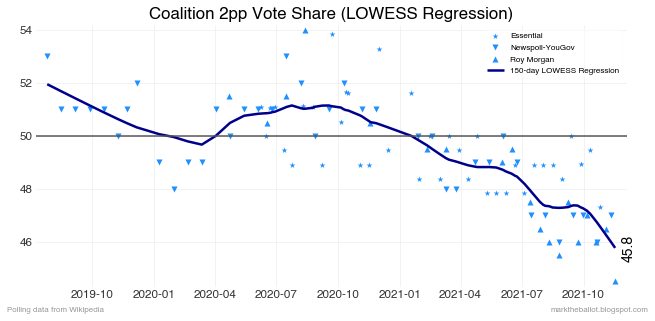

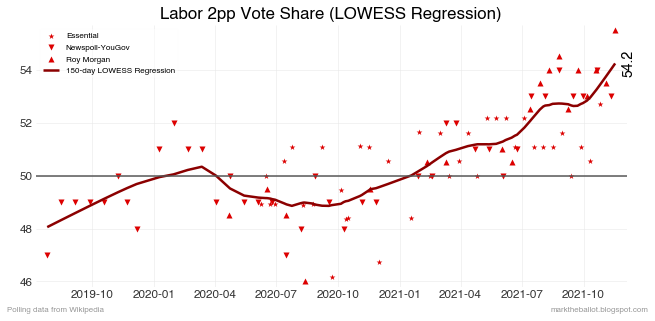

In [29]:
lowess = plot_points_lowess(tpp,
                            '2pp vote L/NP', 
                            'dodgerblue', 
                            'darkblue', 
                            f'Coalition 2pp Vote Share ({MODEL_NAME})')

plot_points_lowess(tpp, 
                   '2pp vote ALP', 
                   '#dd0000', 
                   'darkred', 
                   f'Labor 2pp Vote Share ({MODEL_NAME})')

tpp['2pp Vote L/NP LOWESS'] = lowess.values

### Plot calculated 2pp

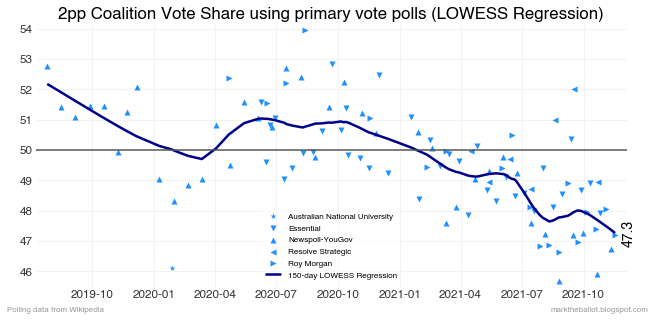

In [30]:
calculated = pv[['Brand', 'Mean Date', 'Calculated 2pp L/NP']]
title = f'2pp Coalition Vote Share using primary vote polls ({MODEL_NAME})'
_ = plot_points_lowess(calculated, 'Calculated 2pp L/NP', 'dodgerblue', 'darkblue', title)

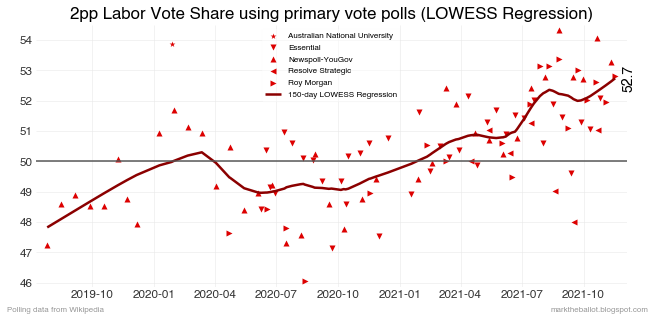

In [31]:
calculated = pv[['Brand', 'Mean Date', 'Calculated 2pp ALP']]
title = f'2pp Labor Vote Share using primary vote polls ({MODEL_NAME})'
_ = plot_points_lowess(calculated, 'Calculated 2pp ALP', '#dd0000', 'darkred', title)

### Primary votes

In [32]:
def get_primary_data(pv, party, cols):
    data = pv[cols].sum(axis=1, skipna=True)
    data.name = party
    data = data[data > 0] # ignore NaNs mapped to zero
    
    returnable = pv[pv.columns[pv.columns.isin(['Brand', 'Mean Date'])]].copy()
    returnable[party] = data
    
    return returnable

In [33]:
primaries = {
    'Coalition': [['Primary vote L/NP'], 'dodgerblue', 'darkblue'],
    'Labor': [['Primary vote ALP'], '#dd0000', 'darkred'],
    'Green': [['Primary vote GRN'], 'green', 'darkgreen'],
    'Others': [['Primary vote ONP', 'Primary vote OTH'], 'orange', 'darkorange'],
}

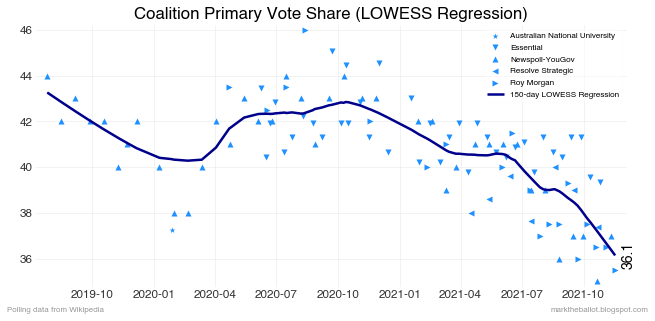

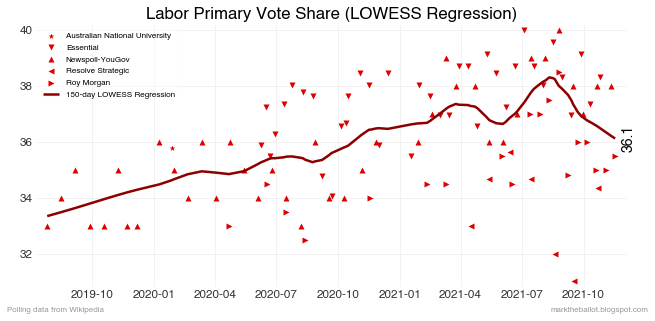

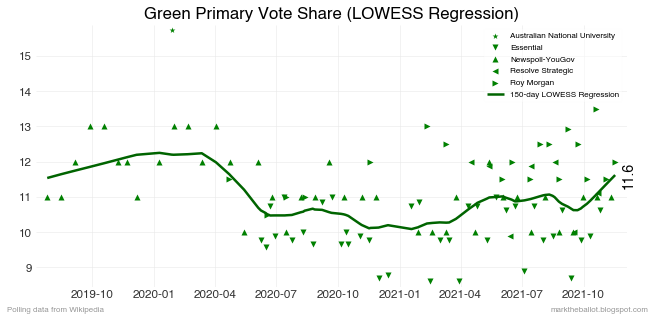

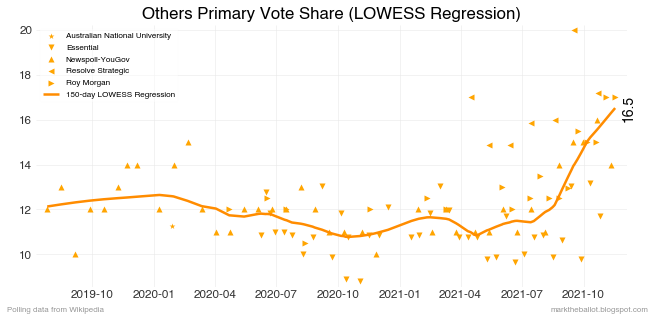

In [34]:
for party, (cols, point_c, line_c) in primaries.items():
    df = get_primary_data(pv, party, cols)
    title = f'{party} Primary Vote Share ({MODEL_NAME})'
    plot_points_lowess(df, party, point_c, line_c, title)

### Preferred Prime Minister

In [35]:
def ppm_charts(df, columns, title):

    ax = None
    label = True
    for col, (name, p_color, l_color) in columns.items():
        fig, ax = plot_data_points(ppm, col, p_color, ax=ax, label=label)
        label = False # avoid repeated labels
        lowess, _ = get_lowess(ppm[col], ppm['Mean Date'])
        ax.plot(lowess.index, lowess, c=l_color, lw=2.5, label=name)
    ax.legend(loc='best', ncol=2)
    common.plot_finalise(ax, title=title, **s_args)

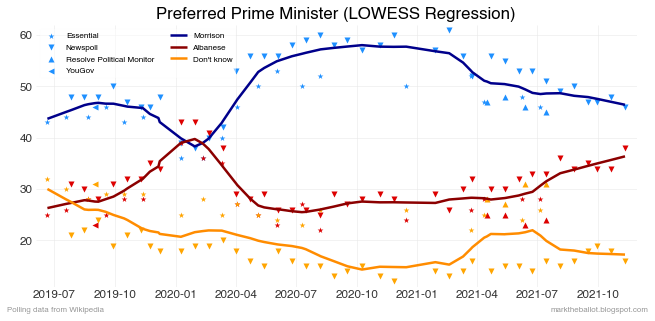

In [36]:
columns = {
    ('Preferred Prime Minister Morrison'): ['Morrison', 'dodgerblue', 'darkblue'],    
    ('Preferred Prime Minister Albanese'): ['Albanese', '#dd0000', 'darkred'],    
    ("Preferred Prime Minister Don't Know"): ["Don't know", 'orange', 'darkorange'],    
}

title = f'Preferred Prime Minister ({MODEL_NAME})'
ppm_charts(ppm, columns, title)

### Satisfaction charts

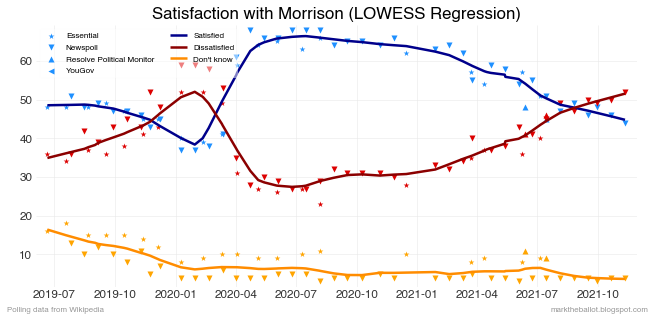

In [37]:
columns = {
    ('Morrison Satisfied'): ["Satisfied", 'dodgerblue', 'darkblue'],    
    ('Morrison Dissatisfied'): ["Dissatisfied", '#dd0000', 'darkred'],    
    ("Morrison Don't Know"): ["Don't know", 'orange', 'darkorange'],    
}

title = f'Satisfaction with Morrison ({MODEL_NAME})'
ppm_charts(ppm, columns, title)

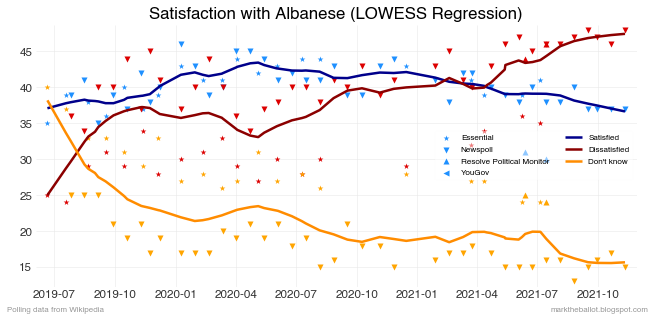

In [38]:
columns = {
    ('Albanese Satisfied'): ["Satisfied", 'dodgerblue', 'darkblue'],    
    ('Albanese Dissatisfied'): ["Dissatisfied", '#dd0000', 'darkred'],    
    ("Albanese Don't Know"): ["Don't know", 'orange', 'darkorange'],    
}

title = f'Satisfaction with Albanese ({MODEL_NAME})'
ppm_charts(ppm, columns, title)

## Save files

In [39]:
# and save to file
tpp.to_csv(f'{DATA_DIR}two_party_preferred.csv')
pv.to_csv(f'{DATA_DIR}primary_vote.csv')
ppm.to_csv(f'{DATA_DIR}preferred_prime_minister.csv')

## Check for any problems with data capture and cleaning

In [40]:
check_warnings()
# Note you should go back and check any warnings that appear here ...

1: check_row_sums() found issues with Primary vote
2: check_row_sums() found issues with Albanese
3: There is a substantial mismatch with pollster 2pp at
	[datetime.date(2021, 11, 17)]
